# Modelling the Characteristics of People Earning Above $50k 

Objective is to model characteristics of people earning above $50k from US census data

In [ ]:
#import required libraires for modelling and data anlaysis 
import pandas as pd 
import numpy as np 
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost

In [2]:
# DATA LABELS 
colpos = np.arange(start=0,stop=42,step=1)
print(colpos)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [3]:
#READ IN DATA

#Read in .txt file with meta data
mylines = []                              # Declare an empty list
with open (r'C:\Users\johna\OneDrive\Documents\DataIku\census_income_metadata.txt') as myfile:  # Open file lorem.txt
    for line in myfile:                  # For each line of text,
        mylines.append(line)              # add that line to the list.
    #for element in mylines:               # For each element in the list,
        #print(element, end='')            # print it without extra newlines.

        
#give columns labels based on position var0 to var41
columns = []

for i in colpos:
    columns.append('var'+ str(colpos[i]))

#colnames_training = colnames.append('label')

#Import the test and train csv and remove an whitespace from
Training = pd.read_csv(r'C:\Users\johna\OneDrive\Documents\DataIku\census_income_learn.csv', delimiter=',', encoding="utf-8", skipinitialspace=True, names=columns)
Test = pd.read_csv(r'C:\Users\johna\OneDrive\Documents\DataIku\census_income_test.csv', delimiter=',', encoding="utf-8", skipinitialspace=True, names=columns)

#Training.name = 'Trianing'
#Test.name = 'Test'

#Training.head()



# Data Wrangling
Raw data had missing observations, data quality issues, features with high cardinality and coded variables. These are handled by removing or re-categorising.

In [4]:
#DATA WRANGLING AND FEATURE ENGINEERING

#Drop duplicate observations 
Training = Training.drop_duplicates()

def clean_data(df):
    

    #There are a number of features with a high proportion of missing variables. It's sensible to drop these features from the analysis (shown in hisotgram plots)
    DropFeatures = ['var25','var26','var27','var29','var31','var32','var33','var40']
    df.drop(DropFeatures,axis=1, inplace=True)

    #Some features are encoded numerically without some udnerstanding of what these codes translate to there is no sense including them in the model
    DropFeatures2 = ['var38','var36','var2','var3']
    df.drop(DropFeatures2,axis=1,inplace=True)

    #Var8 and var9 indicate occupational and industry codes. Large proportion are marked 'Children or Not in unvierse' even after controlling for age (18+)
    #There are possibly some data quality issues with these fields so they are dropped from analysis

    DropFeatures3 = ['var8','var9']
    df.drop(DropFeatures3,axis=1,inplace=True)

    #Var15 indicates employement status whether full or part time employment. There are a large number of observations under 'Children or Armed Forces'
    # There could also be some data quality issues with this field as we do not see many observations under 'Armed Forces' for occupational (var9) or indsutrial codes (var8)
    # even after controlling for children in the population. 
    DropFeatures4 = ['var15']
    df.drop(DropFeatures4,axis=1,inplace=True)

    #Drop var20 as it's similar to var21,
    DropFeatures5 = ['var20']
    df.drop(DropFeatures5,axis=1,inplace=True)

    #Drop var28 (live in this house 1 year ago) as there are an abnormally high number of people tnat didn't lived in their homes under 1 year 
    DropFeatures6 = ['var28']
    df.drop(DropFeatures6,axis=1,inplace=True)

    #Drop var22 (detailed household and family stat), has a large number of categories and is reflected in var23 
    DropFeatures7 = ['var22']
    df.drop(DropFeatures7,axis=1,inplace=True)
    
    #Drop var34 (country of birth) due to high dimensionality 
    DropFeatures8 = ['var34']
    df.drop(DropFeatures8,axis=1,inplace=True)
    
    #Suspect that var24 is instance weight. Dropping from the model as not useful for classification
    DropFeatures9 = ['var24']
    df.drop(DropFeatures9,axis=1,inplace=True)
    
    #var39 relates to year simplify analysis by droping this.
    DropFeatures10 = ['var39']
    df.drop(DropFeatures10,axis=1,inplace=True)
    
    #Var1 Unknown employment status
    df.loc[(df.var1 == 'Not in universe','var1')] = 'Worker Class: Unknown'
    
    #var4 (education) has high cardinality and high proportion of observation marked as 'Children', which is ambiguous
    #recategories field to university educated vs non-university educated
    df.loc[(df.var4 == 'Associates degree-academic program', 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Associates degree-occup /vocational', 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Bachelors degree(BA AB BS)', 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Doctorate degree(PhD EdD)', 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Masters degree(MA MS MEng MEd MSW MBA)', 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Prof school degree (MD DDS DVM LLB JD)' , 'var4')] = 'University Educated'
    df.loc[(df.var4 == 'Some college but no degree', 'var4')] = 'University Educated'
    df.loc[(df.var4 != 'University Educated','var4')] = 'Non-University Educated'

    #Var6 (enroll in edu inst last wk) assume 'Not in universe' (NIU) as not-enrolled in education, otherwise enrolled
    df.loc[(df.var6 == 'Not in universe','var6')] = 'Not enrolled in Edu'
    df.loc[(df.var6 != 'Not enrolled in Edu','var6')] = 'Enrolled in Edu'

    #var11 (hispanic origin) re-code All other to Non-hispanic
    df.loc[(df.var11 == 'All other','var11')] = 'Non-Hispanic'
    df.loc[(df.var11 == 'Do not know','var11')] = 'Non-Hispanic'
    df.loc[(df.var11 == 'Other Spanish','var11')] = 'Non-Hispanic'
    #There are some missing values in variable 11 (hispanic origin). There are only a small fraction so they will be inputed with the mode of the variable
    df.var11.fillna('Non-Hispanic', inplace = True)
    df.loc[(df.var11 != 'Non-Hispanic','var11')] = 'Hispanic'

    #var13 (member of a labor union) assume NIU as No Labor Union
    df.loc[(df.var13 == 'Not in universe','var13')] = 'No Labor Union'
    df.loc[(df.var13 == 'No','var13')] = 'Labour Union: Non-Member'
    df.loc[(df.var13 == 'Yes','var13')] = 'Labour Union: Member'

    #var14 (reason for unemployment) assume NIU to be employed and all other categores assum unemployed
    df.loc[(df.var14 == 'Not in universe','var14')] = 'Employed'
    df.loc[(df.var14 != 'Employed','var14')] = 'Unemployed'

    #Var21 (state of previous residence) re-categorise to moved states and not moved states
    df.loc[(df.var21 == 'Not in universe','var21')] = 'Moved States: No'
    df.loc[(df.var21 != 'Moved States: No','var21')] = 'Moved Sates: Yes'

    #Var23 can be grouped into householder and non-householder
    df.loc[(df.var23 != 'Householder','var23')] = 'Non-Householder'

    #var37 (veterans benefits) if NIU then non-veteran/Civilian else veteran 
    df.loc[(df.var37 == 'Not in universe','var37')] = 'Non-Veteran or Civilian'
    df.loc[(df.var37 != 'Non-Veteran or Civilian','var37')] = 'Veteran'
    
    #Remove observations under 18, legal ag of adulthood in US
    df = df.loc[(df.var0 > 18)]

    return(df)

Training = clean_data(Training)
Test = clean_data(Test)


In [5]:
#DEFINE FUNCTIONS FOR FREQUENCY PLOTS AND HISTOGRAMS
def Freqplot(df):
    features = df.select_dtypes(include =['object']).columns 
    for i in features:
        df[i].value_counts().plot(kind='bar')
        plt.title(i)
        plt.show()
        
def histogram(df,no_ofbins):
    features = df.select_dtypes(include =['int64','float64']).columns
    for i in features:
        #plt.figure(figsize=(10,10))
        ax = sns.distplot(df[i], bins=no_ofbins)
        plt.show()

In [6]:
#DATA ANALYSIS AND CLEANING CLEANING: 
%matplotlib inline

    

#plot histograms
#df = Test
#no_ofbins = 24
#histogram(df,no_ofbins)
#plot frequency plots
#Freqplot(df)
#Training_exp.head()





# Feature Engineering 

Predicting incomes in a task that requires supervised machine learning therefore categorical features need to be numerically encoded. I've used one hot encoding to do this. One hot encoding has a wrapper to create column labels.

Wrapper taken from: https://towardsdatascience.com/how-to-assign-labels-with-sklearn-one-hot-encoder-e59a5f17df4f

In [7]:
#CREATE ONE HOT ENCODING OBJECT TO TRANSFORM  DATA FOR MODELS
#import onehot encoder
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder , LabelEncoder


#wrapper for one hot encoder to allow labelling of encoded variables 
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns


#define a function to transform data to get dummy variabkes with onehot encoder 
#AND rename continous variables so that they can be interprted 

def transform(df):
    cat_columns = df.select_dtypes(include =['object']).columns
    num_columns = df.select_dtypes(include = ['float64','int64']).columns
    ohe = OneHotEncoder( handle_unknown="ignore")
    df_processed = ohe.fit_transform(df[cat_columns])
    
    #remove unwanted characters from column names
    df_processed.columns = df_processed.columns.str[6:-1]
    df_processed.columns = df_processed.columns.str.replace('<','')
    
    
    #concatinate numeric features from orginal tables with encoded features
    df_processed_full = pd.concat([df_processed,df[num_columns]],axis=1)
    # drop colum var41_<- 50000.> 
    
    
    df_processed_full.drop(['- 50000.'],axis=1,inplace=True)
    
    df_processed_full.rename(columns={"var0":"age",
                                      "var5":"Hourly Wage",
                                      "var16":"Capital Gains",
                                      "var17":"Capital Losses",
                                      "var18":"Dividends Earned",
                                      "var30":"Family Mmebers Under 18",
                                      '50000+.':"Over $50k"},inplace=True)
    
    df_processed_full = df_processed_full.astype(np.int)
    
    return(df_processed_full)
 


Training_transformed = transform(Training)
Test_transformed = transform(Test)



X_train = Training_transformed.drop(['Over $50k'], axis=1)
Y_train = Training_transformed['Over $50k']

X_test = Test_transformed.drop(['Over $50k'], axis=1)
Y_test = Test_transformed['Over $50k']

Training_transformed.head()
#print(label_encoders)




,Federal government,Local government,Never worked,Private,Self-employed-incorporated,Self-employed-not incorporated,State government,Without pay,Worker Class: Unknown,Non-University Educated,...,Native- Born in the United States,Non-Veteran or Civilian,Veteran,Over $50k,age,Hourly Wage,Capital Gains,Capital Losses,Dividends Earned,Family Mmebers Under 18
0,0,0,0,0,0,0,0,0,1,1,...,1,1,0,0,73,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,58,0,0,0,0,1
5,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,48,1200,0,0,0,1
6,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,42,0,5178,0,0,6
7,0,0,0,1,0,0,0,0,0,1,...,1,1,0,0,28,0,0,0,0,4


# Modelling

Three models used were logistic regression, decision tree and xgboost. Xgboost outperformed the other two models but is the most difficult to draw insights from. Logistic regression was the fastest to train and is easy to draw directional insights from.

The modelling followed ML best practices using 6 fold cross validation for parameter tuning and evaluation on the test set.




C:\Users\johna\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Mean accuracy for 6 Fold Cross Validation: 0.798863741142926 Accuracy score on test: 0.7999292986425339 Best estimator Paramters: {'C': 100, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': 'True', 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Logisitc Regression
[[0.8  0.2 ]
 [0.19 0.81]]


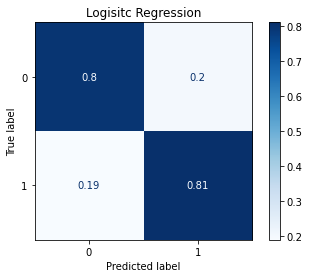

,Weights,Odds Ratio
Nonfiler,-1.350518,0.259106
Worker Class: Unknown,-1.330334,0.264389
Self-employed-incorporated,1.288704,3.628080
Enrolled in Edu,-1.120891,0.325989
Non-University Educated,-1.110937,0.329250
Female,-0.969742,0.379181
Unemployed,-0.722294,0.485637
Hispanic,-0.708617,0.492324
Joint both under 65,0.634122,1.885367
State government,-0.558016,0.572344


In [8]:
#Model 1: Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix



#set initial paramters for logistic regression 
#class weight is set to balanced to account for imbalance in sample
params = {'solver':'liblinear', 
          'fit_intercept':'True', 
          'class_weight':'balanced'}

LogReg = LogisticRegression(**params)

distributions = dict(C=[0.1,1,10,100],penalty=['l2','l1'])


#Use randomized search to tune hyper paramters
#C, L1 and L2
#L1 is Lasso regularisation which performs feature selection
#scoring is set to recore to optimise true positive rate
Tuned_LogReg = RandomizedSearchCV(LogReg, distributions, random_state=0, scoring = 'accuracy', cv=6)

Tuned_LogReg.fit(X_train,Y_train)

#Predict label using model

Y_pred = Tuned_LogReg.predict(X_test)


print('Mean accuracy for 6 Fold Cross Validation:',Tuned_LogReg.score(X_train,Y_train),
      'Accuracy score on test:',accuracy_score(Y_test,Y_pred),
       'Best estimator Paramters:', Tuned_LogReg.best_estimator_.get_params()
     )


#Plot confusion matrix

title = 'Logisitc Regression'
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(Tuned_LogReg.best_estimator_, X_test, Y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()


#OUTPUT LOGISTIC REGRESSION MODEL TO A TABLE WITH PARAMTERS 

values = list(Tuned_LogReg.best_estimator_.coef_[0])
keys = list(X_train.columns)

Model_Output = {keys[i]: values[i] for i in range(len(keys))}

Model_Output = pd.DataFrame.from_dict(Model_Output,orient='index')

Model_Output.columns = ['Weights']

Model_Output = Model_Output.loc[Model_Output['Weights']!=0]

Model_Output['Odds Ratio'] = np.exp(Model_Output.Weights)

Model_Output2 = Model_Output.iloc[(-np.abs(Model_Output['Weights'].values)).argsort()]

Model_Output2.head(25)

C:\Users\johna\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Mean accuracy for 6 Fold Cross Validation: 0.8776421374329997 Accuracy score on test: 0.775593891402715 Paramters: {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Decision Tree
[[0.77 0.23]
 [0.16 0.84]]


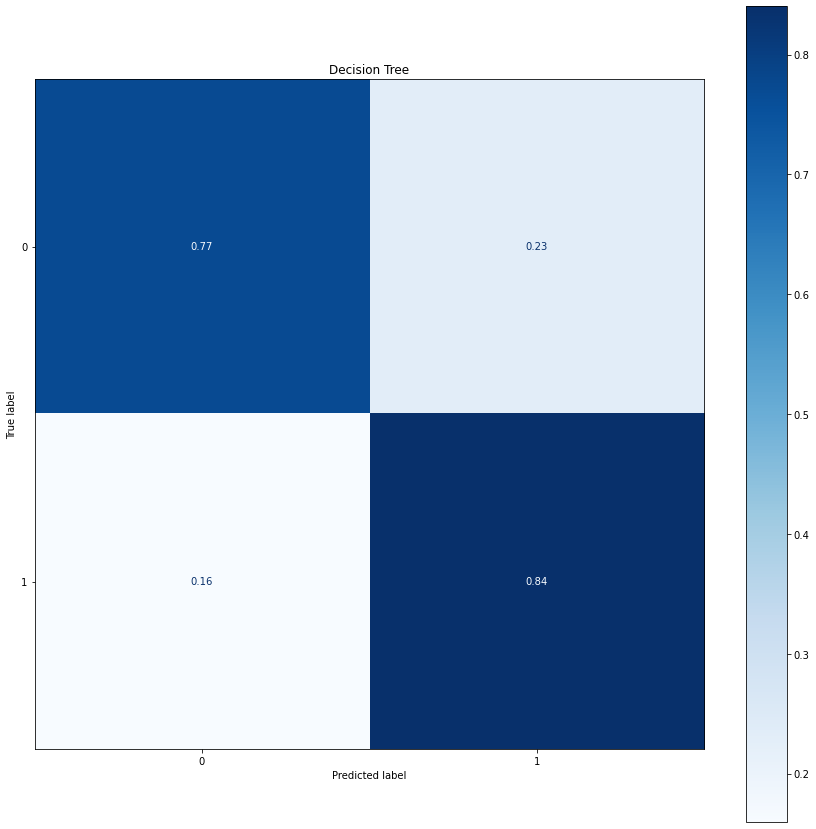

<function matplotlib.pyplot.show(*args, **kw)>

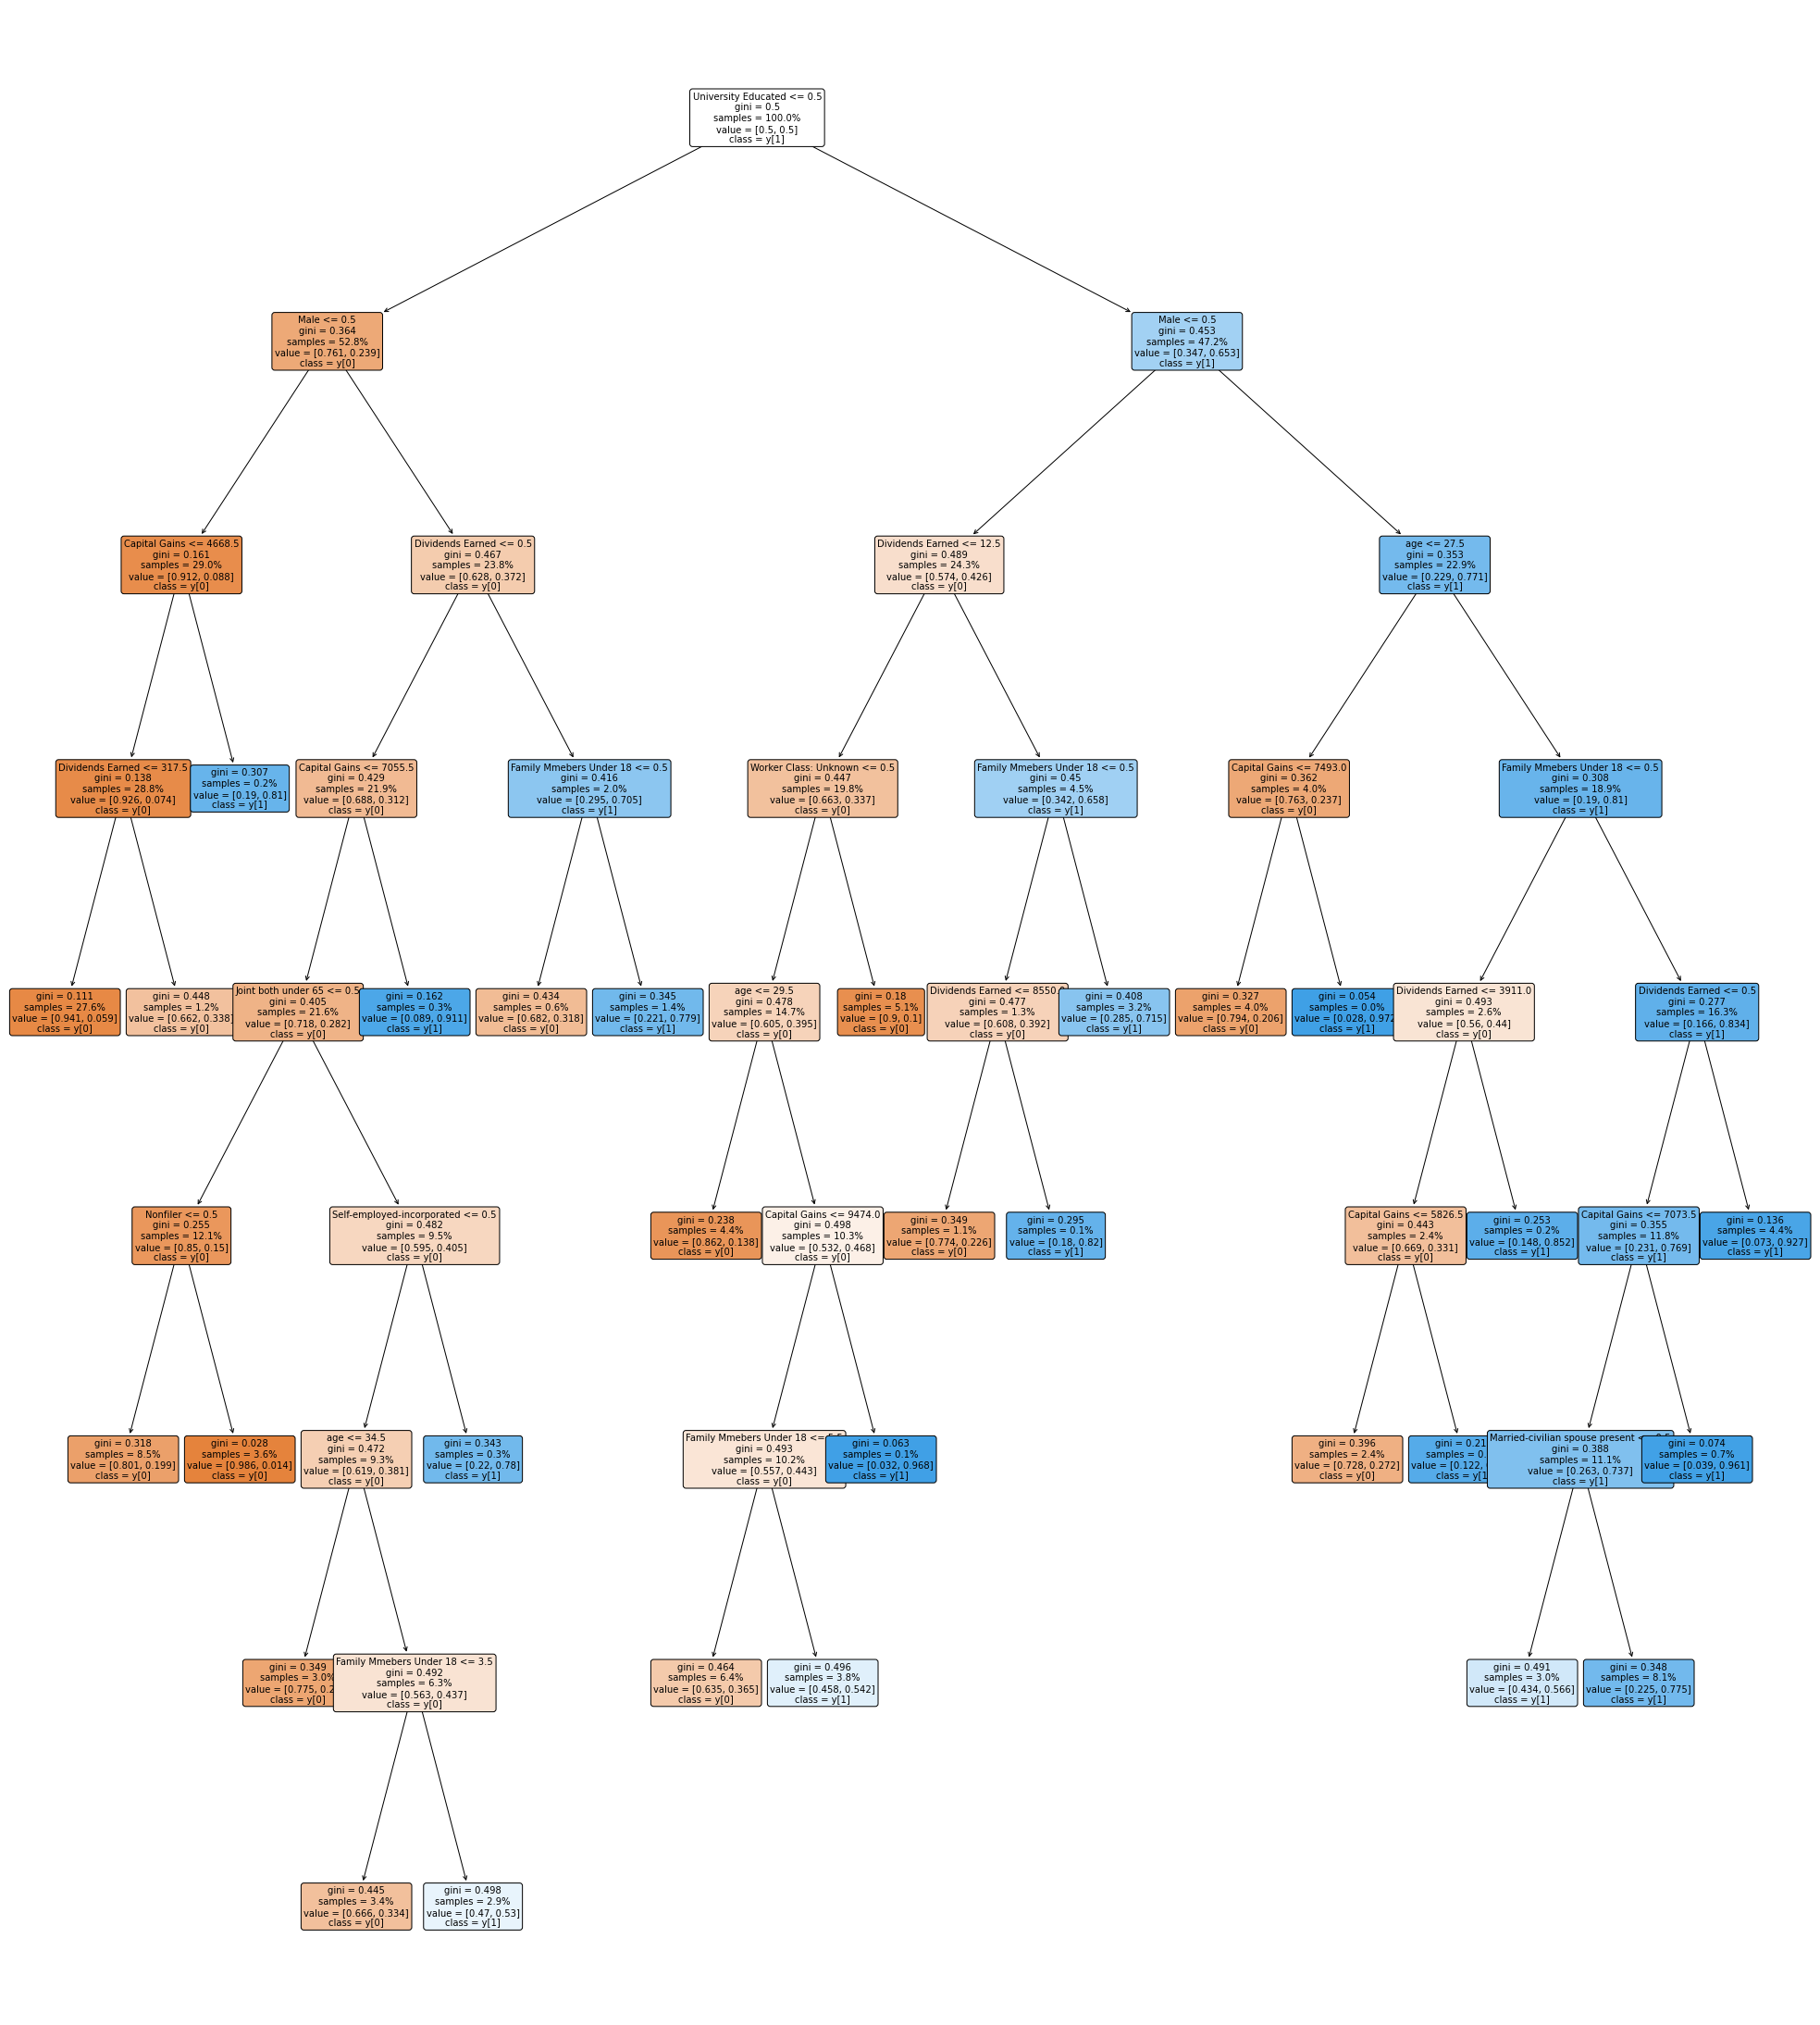

In [17]:
#Model 2: Decision Tree 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import datasets

#Decision tree classifier with cost complexity pruning (ccp_alpha)
params = {'criterion':'gini', 'class_weight':'balanced'}

DecisionTree = DecisionTreeClassifier(**params)

#set random search params
distributions = dict(ccp_alpha=[0.001,0.01,0.03],
                    max_depth=[6,7,8])

#Create random search cross validation object with 
DecisionTree_Tuned = RandomizedSearchCV(DecisionTree, distributions, random_state=0, scoring = 'roc_auc', cv=6)

#fit tuned tree
DecisionTree_Tuned.fit(X_train,Y_train)

#Predict label
Y_pred = DecisionTree_Tuned.predict(X_test)

#print paramters for best model
print('Mean accuracy for 6 Fold Cross Validation:',DecisionTree_Tuned.score(X_train,Y_train),
      'Accuracy score on test:',accuracy_score(Y_test,Y_pred),
       'Paramters:', DecisionTree_Tuned.best_estimator_.get_params() )


#Plot confusion matrix
title = 'Decision Tree'
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(DecisionTree_Tuned.best_estimator_, X_test, Y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

#Plot Decision Tree
featurenames = X_train.columns


fig, ax = plt.subplots(figsize=(35, 40))
sklearn.tree.plot_tree(DecisionTree_Tuned.best_estimator_, feature_names = featurenames, fontsize=10,
                      rounded = True, filled = bool, label='all', impurity= True, proportion=True,
                      class_names = True )
plt.show



In [10]:
print(Y_train.shape)
print(X_train.shape)

(140989,)
(140989, 57)


Mean accuracy for 5 Fold Cross Validation: 0.8432829792390338 Accuracy score on test: 0.8502686651583711 Paramters: {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.2, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0.1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 9, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'error'}
XGBoost
[[0.85 0.15]
 [0.19 0.81]]


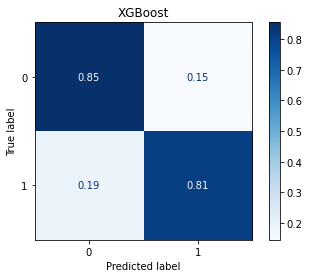

In [11]:
#Model 3: xgboost
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 

params ={'objective' : 'binary:logistic',
         'eval_metric' : 'error',
         'colsample_bytree':1,
         'reg_alpha': 1,
         'min_child_weight':0.1
         
         }

# define model
BoostMod = XGBClassifier(**params)

#set search distributions 
distributions = dict(
                     max_depth = [6,8], # Optimise depth of treee
                     n_estimators = [100,250,500,750], #number of trees
                     learning_rate = [0.1,0.2,0.3], 
                     scale_pos_weight  = [7,8,9] # scale pos weight to account for class imbbalance in data 
                     
                    )

#Create random search cross validation object with 
BoostMod_Tuned = RandomizedSearchCV(BoostMod, distributions, scoring = 'recall', cv=6, random_state=0)

# Fit model
BoostMod_Tuned.fit(X_train,Y_train)

# Predict label
Y_pred = BoostMod_Tuned.predict(X_test)

#print paramters for best model
print('Mean accuracy for 5 Fold Cross Validation:',BoostMod_Tuned.score(X_train,Y_train),
      'Accuracy score on test:',accuracy_score(Y_test,Y_pred),
       'Paramters:', BoostMod_Tuned.best_estimator_.get_params()
     )

title = 'XGBoost'
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(BoostMod_Tuned.best_estimator_, X_test, Y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

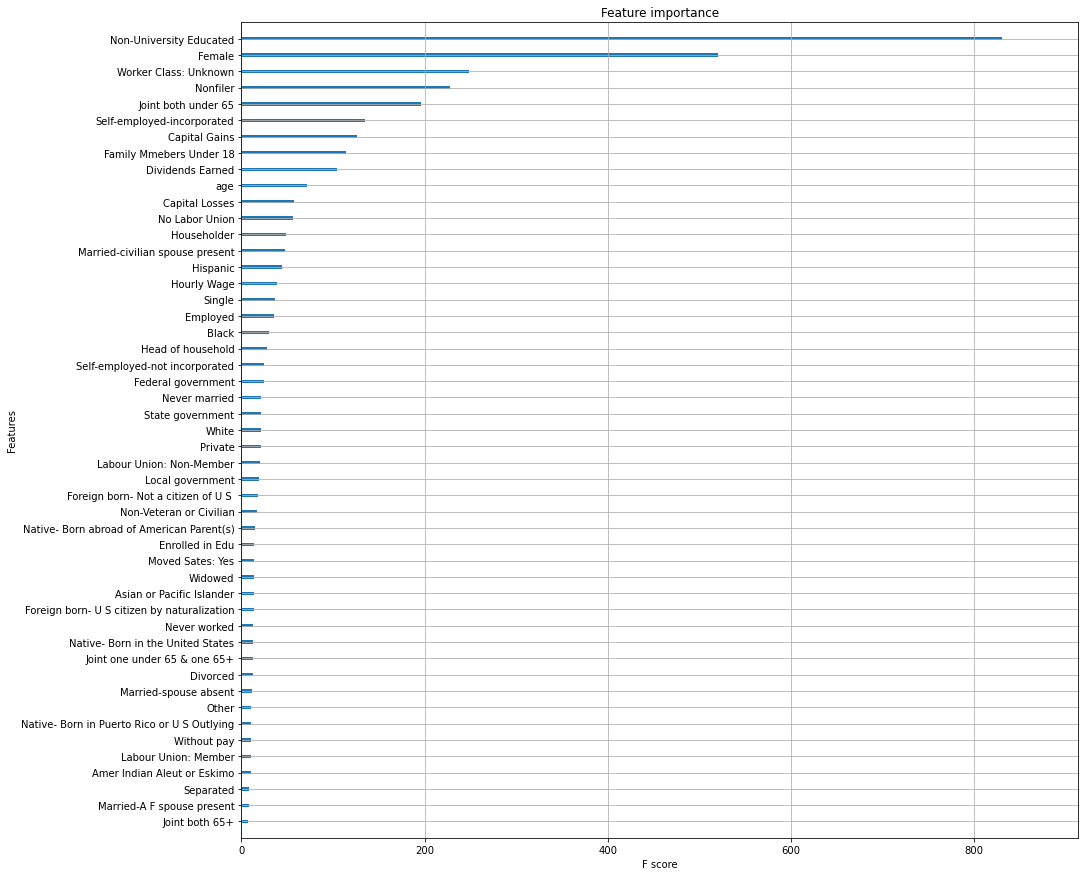

In [14]:
xgb.plot_importance(BoostMod_Tuned.best_estimator_, importance_type='gain', show_values=False)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

In [13]:
import matplotlib

#matplotlib.rcParams['figure.figsize'] = (10, 10)
